<a href="https://colab.research.google.com/github/joebathelt/AUC_Neuroimaging/blob/main/MindReading_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4: Age Prediction from Brain Structure

In this week, we will explore how to predict a person's age based on the structure of their brain. We will use a dataset that contains MRI scans of the brain, along with the corresponding ages of the individuals. The goal is to build a machine learning model that can accurately predict age from these brain scans.

**Learning Objectives**:
- Learn how to implement a machine learning model for regression tasks.
- Understand the difference between linear regression and regularized regression (Ridge).
- Understand how to use cross-validation to prevent overfitting and to tune hyperparameters.
- Learn how to use train-test splits to evaluate model performance.
- Use metrics to evaluate model performance.

**Estimated time to complete:** 1 hour

### Loading the Data
For this tutorial, we will make use of the AOMIC dataset again. Specifically, we will load tabular data that contains demographi information about the participants, including their ages. We will also load the output of the Freesurfer pipeline, which contains the cortical thickness of brain areas in the Desikan-Killiany atlas.

In [ ]:
import os
import urllib.request

def download_file(url, outfile):
    """Download file from URL if not already present."""
    if not os.path.exists(outfile):
        print(f"Downloading {outfile}...")
        urllib.request.urlretrieve(url, outfile)
        print(f"Saved as {outfile}")
    else:
        print(f"{outfile} already exists, skipping download.")

# Downloading some required data
download_file(
    "https://www.dropbox.com/scl/fi/8jn6ie3mm9kveok74jjyy/data-cortical_type-aparc_measure-thickness_hemi-lh.tsv?rlkey=t7b7zy0vk5dv5l7ncn0ynb9ln&dl=1",
    "data-cortical_type-aparc_measure-thickness_hemi-lh.tsv"
)

download_file(
    "https://www.dropbox.com/scl/fi/h24blpi07kn88ynfw0ovp/data-cortical_type-aparc_measure-thickness_hemi-rh.tsv?rlkey=vjq9yd192bl58befxbycb8nk5&dl=1",
    "data-cortical_type-aparc_measure-thickness_hemi-rh.tsv"
)

download_file(
    "https://www.dropbox.com/scl/fi/dzn0kre1os4to7v88o2fz/participants.tsv?rlkey=7tv75ssq9386wcw2l1lsgly1h&dl=1",
    "participants.tsv"
)

Saved as data-cortical_type-aparc_measure-thickness_hemi-lh.tsv
Saved as data-cortical_type-aparc_measure-thickness_hemi-rh.tsv
Saved as participants.tsv


In [ ]:
# Loading the data
import pandas as pd

lh_thickness = pd.read_csv("data-cortical_type-aparc_measure-thickness_hemi-lh.tsv", sep="\t")
rh_thickness = pd.read_csv("data-cortical_type-aparc_measure-thickness_hemi-rh.tsv", sep="\t")
participants = pd.read_csv("participants.tsv", sep="\t")

# Only use the thickness columns
lh_thickness = lh_thickness[[column for column in lh_thickness.columns if "thickness" in column]]
lh_thickness = lh_thickness[[column for column in lh_thickness.columns if not "MeanThickness" in column]]
rh_thickness = rh_thickness[[column for column in rh_thickness.columns if "thickness" in column]]
rh_thickness = rh_thickness[[column for column in rh_thickness.columns if not "MeanThickness" in column]]

# Rename the ID columns
lh_thickness.rename(columns={"lh.aparc.thickness": "participant_id"}, inplace=True)
rh_thickness.rename(columns={"rh.aparc.thickness": "participant_id"}, inplace=True)

# Only use ID and age columns from the participants file
participants = participants[["participant_id", "age"]]

# Show an overview of the data
print('Participants:')
print(participants.head())
print('--------------------')
print('Left hemisphere thickness (shape):')
print(lh_thickness.shape)
print('--------------------')
print('Right hemisphere thickness (shape):')
print(rh_thickness.shape)

Participants:
  participant_id    age
0       sub-0001  22.00
1       sub-0002  21.75
2       sub-0003  25.25
3       sub-0004  22.50
4       sub-0005  22.25
--------------------
Left hemisphere thickness (shape):
(928, 35)
--------------------
Right hemisphere thickness (shape):
(928, 35)


As you can see from the output of the `head()` function, the demographic data contains a column called `age` that contains the ages of the participants. The other two dataframes contain the cortical thickness of brain areas in the left and right hemisphere (34 area per hemisphere). Our first step is to merge these three dataframes into a single dataframe that contains the ages and the cortical thickness of all brain areas for each participant. We will use the `participant_id` column to merge the dataframes.

In [ ]:
# Merging the dataframes
merged_df = pd.merge(participants, lh_thickness, on="participant_id")
merged_df = pd.merge(merged_df, rh_thickness, on="participant_id")

print(merged_df.head())

  participant_id    age  lh_bankssts_thickness  \
0       sub-0001  22.00                  2.597   
1       sub-0002  21.75                  2.697   
2       sub-0003  25.25                  2.647   
3       sub-0004  22.50                  2.594   
4       sub-0005  22.25                  2.703   

   lh_caudalanteriorcingulate_thickness  lh_caudalmiddlefrontal_thickness  \
0                                 2.861                             2.832   
1                                 2.827                             2.823   
2                                 2.924                             2.825   
3                                 2.468                             2.832   
4                                 2.656                             2.674   

   lh_cuneus_thickness  lh_entorhinal_thickness  lh_fusiform_thickness  \
0                1.666                    3.718                  2.751   
1                2.003                    3.834                  2.972   
2             

Before we get into the machine learning model, we can check if there is a relationship between age and cortical thickness by plotting the data. We can create a scatter plot of age against the average cortical thickness across all brain areas for each participant.

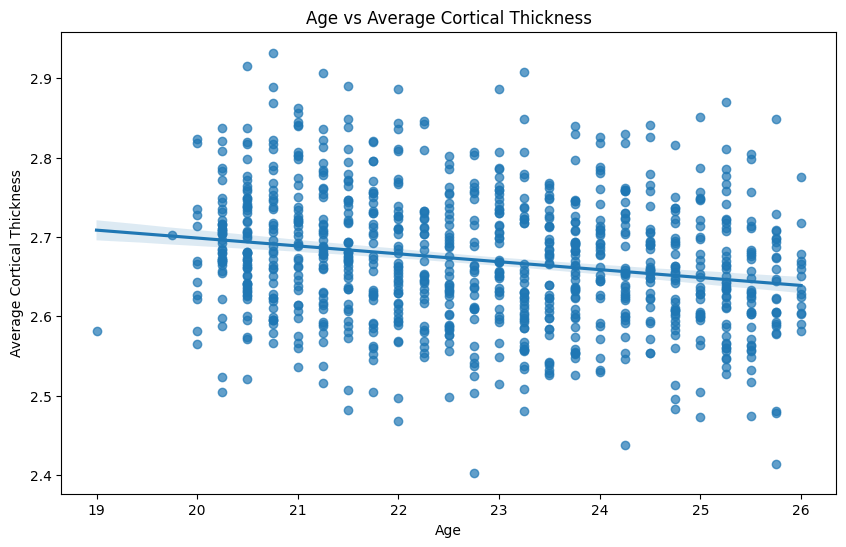

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average cortical thickness across all brain areas for each participant
plotting_df = merged_df.copy()
plotting_df['average_thickness'] = plotting_df[[column for column in plotting_df.columns if "thickness" in column]].mean(axis=1)

# Create a scatter plot of age against average cortical thickness
plt.figure(figsize=(10, 6))
sns.regplot(x='age', y='average_thickness', data=plotting_df, scatter_kws={'alpha':0.7})
plt.title('Age vs Average Cortical Thickness')
plt.xlabel('Age')
plt.ylabel('Average Cortical Thickness')
plt.show()

This looks like there is a negative association between age and average cortical thickness, even within this narrow age range. Let's see if we can build a machine learning model that can predict age from the cortical thickness of brain areas.

One important aspect to consider when building machine learning models is to prevent overfitting. Overfitting occurs when a model learns the training data too well, including the noise, and performs poorly on new, unseen data. For instance, one older participant may have weird data, e.g. a very low cortical thickness because of an error during preprocessing. If our model learns this noise, it will not generalize well to new data. To prevent overfitting, we can use cross-validation and train-test splits.

First, we will split our data into a training set and a test set. The training set will be used to train the model, while the test set will only be used to evaluate the model's performance on unseen data. We will use an 80-20 split, where 80% of the data is used for training and 20% is used for testing. It is very important that we do this before we do any further steps, such as feature selection or scaling, to prevent data leakage. Data leakage occurs when information from the test set is used to create the model, which can lead to overly optimistic performance estimates. Fitting and testing models on the same data is the cardinal sin of machine learning, so we will make sure to avoid this at all costs.



In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and test sets (80% training, 20% testing)
# Note that the split is random, but we set a random state so that we get the same split every time we run the code (important for reproducibility).
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

print(f"Training set size: {train_df.shape[0]} participants")
print(f"Test set size: {test_df.shape[0]} participants")

Training set size: 742 participants
Test set size: 186 participants


Next, we implement cross-validation to further prevent overfitting. Cross-validation is a technique that allows us to evaluate the performance of our model on different subsets of the training data. This helps us to ensure that our model is not just learning the noise in the training data, but is actually learning the underlying patterns that can generalize to new data. In our case, we will use K-fold cross-validation, where the training data is split into K subsets (or folds), and the model is trained on K-1 folds and tested on the remaining fold. This process is repeated K times, with each fold being used as the test set once. The performance of the model is then averaged across all K iterations to get a more robust estimate of its performance.

![KFold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_002.png)

The figure above illustrates the logic of K-fold cross-validation. In this example, the data is split into 4 folds (K=4). The model is trained on 3 folds (blue) and tested on the remaining fold (red), and this process is repeated 4 times, with each fold being used as the test set once. You can ignore the `class` and `group` rows in the figure, as they are not relevant for our regression task.

In [ ]:
from sklearn.model_selection import KFold

# Converting the training data into numpy arrays for the predictor (X) and the target variable (y).
# .values converts a pandas DataFrame/Series into a numpy array, which is the format that scikit-learn expects.
# X is a matrix that contains the cortical thickness of all brain areas for each participant, and y is a vector that contains the ages of the participants.
X = train_df.drop(columns=['participant_id', 'age']).values
y = train_df['age'].values

# Defining the K-fold cross-validation object.
# We will use 5 folds, and we will shuffle the data before splitting it into folds to ensure that the data is randomly distributed across the folds.
# We also set a random state for reproducibility.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inspecting the folds
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    print(f"Training size: {len(train_index)} participants")
    print(f"Validation size: {len(val_index)} participants")
    print("--------------------")

**Exercise 1**: Try changing `n_splits` to 3 or 10 in the cell above and re-run it. How do the fold sizes change? What do you think are the trade-offs of using more vs. fewer folds? (Reset to `n_splits=5` before continuing.)

Now that we set up the final evaluation split (outer loop) and the inner cross-validation loop, we can start building our machine learning model.

A natural starting point would be **linear regression**, which fits a straight-line relationship between the brain features and age. However, plain linear regression has no settings (hyperparameters) that we can adjust — it always fits the data in the same way. With 68 brain features and a limited number of participants, this can lead to **overfitting**: the model may rely too heavily on quirks in the training data that do not generalise to new participants.

To address this, we will use **Ridge regression**. Ridge regression works just like linear regression, but adds a penalty that discourages the model from assigning very large weights to any single brain region. The strength of this penalty is controlled by a parameter called **`alpha`**:
- **Small alpha** (e.g. 0.01): almost no penalty → behaves like plain linear regression.
- **Large alpha** (e.g. 100): strong penalty → simpler model that spreads weights more evenly across brain regions.

We will use cross-validation to find the alpha that gives the best performance on unseen data. But first, let's see how a single Ridge model (with a default `alpha=1.0`) performs on each fold:

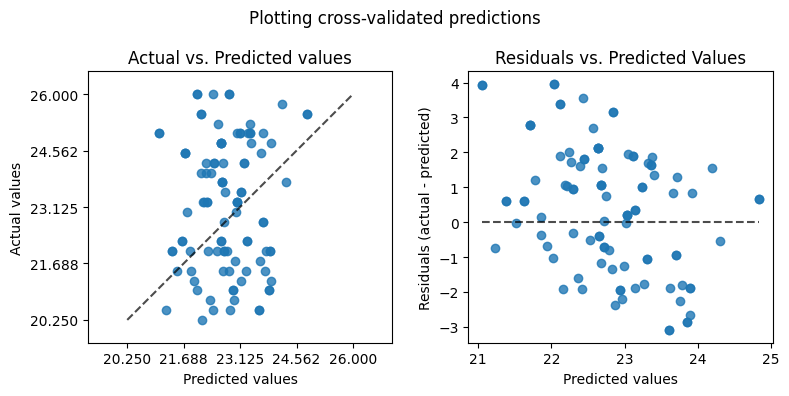

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import PredictionErrorDisplay

# Defining the Ridge regression model with a default alpha of 1.0.
ridge = Ridge(alpha=1.0, fit_intercept=True)

# Fit the model on each fold of the training data
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_val)

# Showing the actual vs. predicted values and the residuals vs. predicted values for the last fold of the cross-validation
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_val,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_val,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

Ideally, we would like a model that predicts ages perfectly (all points on the diagonal line in the left plot). In practice, we will likely see some deviation from this ideal scenario and we would like to quantify how far off our predictions are from the true ages. We can use metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE). MAE is the average absolute difference between the predicted ages and the true ages, while RMSE is the square root of the average squared difference between the predicted ages and the true ages. Both metrics give us an idea of how well our model is performing, with lower values indicating better performance.

In [ ]:
# Calculating the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for the last fold of the cross-validation
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 1.48
Root Mean Squared Error (RMSE): 1.75


**Exercise 2**: The MAE tells us the average prediction error in years. Look at the scatter plot from earlier — the ages in this dataset range from roughly 18 to 30. Given that range, does a MAE of ~1.5 years seem like good or poor performance? What would a "perfect" MAE be, and what would a "useless" model's MAE look like?

In the illustration above, we evaluated the performance in only one fold of the cross-validation, but in practice, we would evaluate the performance in all folds and average the results to get a more robust estimate of the model's performance. Fortunately, we do not have to do this by hand but can use the `cross_val_score` function from scikit-learn, which will automatically perform the cross-validation and return the performance metrics for each fold.

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluating the performance of the Ridge regression model using cross-validation
neg_mae_scores = cross_val_score(ridge, X, y, cv=kf, scoring='neg_mean_absolute_error')
mae_scores = -neg_mae_scores  # Convert to positive MAE scores
print(f"Mean Absolute Error (MAE) for each fold: {mae_scores}")
print(f"Average Mean Absolute Error (MAE): {mae_scores.mean():.2f}")

Mean Absolute Error (MAE) for each fold: [1.48583617 1.40848212 1.46168642 1.35978862 1.47544405]
Average Mean Absolute Error (MAE): 1.44


### Tuning the alpha parameter

So far we used a single alpha value (1.0). But how do we know this is the best choice? This is where cross-validation really shines: we can try **several alpha values**, evaluate each one with K-fold CV, and pick the one with the lowest average error. This process is called **hyperparameter tuning**.

In [ ]:
# Use K-fold cross-validation to select the best alpha for Ridge regression
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
cv_results = {}

for alpha in alphas:
    model = Ridge(alpha=alpha, fit_intercept=True)
    scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    cv_results[alpha] = scores
    print(f"Alpha={alpha:>6}  |  Mean MAE: {scores.mean():.3f}  (± {scores.std():.3f})")

# Select the alpha with the lowest average MAE
best_alpha = min(cv_results, key=lambda a: cv_results[a].mean())
print(f"\nBest alpha: {best_alpha} (MAE = {cv_results[best_alpha].mean():.3f})")

Alpha=  0.01  |  Mean MAE: 1.458  (± 0.046)
Alpha=   0.1  |  Mean MAE: 1.454  (± 0.046)
Alpha=   1.0  |  Mean MAE: 1.438  (± 0.047)
Alpha=  10.0  |  Mean MAE: 1.420  (± 0.055)
Alpha= 100.0  |  Mean MAE: 1.426  (± 0.061)

Best alpha: 10.0 (MAE = 1.420)


We have now built a machine learning model that can predict age from the cortical thickness of brain areas. We can use this model to make predictions on new data and evaluate its performance using the test set that we set aside at the beginning.

In [ ]:
# Retrain the best model on ALL training data, then evaluate on the held-out test set
X_test = test_df.drop(columns=['participant_id', 'age']).values
y_test = test_df['age'].values

final_model = Ridge(alpha=best_alpha, fit_intercept=True)
final_model.fit(X, y)

y_test_pred = final_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
print(f"Final Model (alpha={best_alpha}) on held-out test set:")
print(f"  Test MAE:  {mae_test:.2f}")
print(f"  Test RMSE: {rmse_test:.2f}")
print(f"  (Cross-validation MAE was: {cv_results[best_alpha].mean():.2f})")

Final Model (alpha=10.0) on held-out test set:
  Test MAE:  1.44
  Test RMSE: 1.67
  (Cross-validation MAE was: 1.42)


**Insight**: Our final model showed a mean absolute error of 1.44 in the held-out test set. What does this value mean in the context of age prediction from brain structure? Is this a good performance? Why or why not?

**Insight**: The MAE in our cross-validation was 1.42 compared to 1.44 in the held-out test set. Does that suggest that we have an overfitting problem? Why or why not?

Finally, we can see which brain areas are most important for predicting age by looking at the coefficients of the Ridge regression model. The higher the absolute value of the coefficient, the more important that feature is for predicting age. We can visualize these coefficients to see which brain areas are most strongly associated with age.

In [ ]:
# Print the 10 most important features (brain areas) based on the absolute value of the coefficients
feature_names = [col for col in merged_df.columns if "thickness" in col]
coefficients = final_model.coef_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': abs(coefficients)
})
feature_importance.sort_values(by='abs_coefficient', ascending=False, inplace=True)
print(feature_importance.head(10))

                              feature  coefficient  abs_coefficient
59  rh_rostralmiddlefrontal_thickness     0.607292         0.607292
45               rh_lingual_thickness    -0.560226         0.560226
33                lh_insula_thickness    -0.520702         0.520702
29         lh_supramarginal_thickness    -0.506465         0.506465
21    lh_posteriorcingulate_thickness    -0.474935         0.474935
40      rh_inferiorparietal_thickness    -0.462612         0.462612
62      rh_superiortemporal_thickness    -0.436423         0.436423
55    rh_posteriorcingulate_thickness    -0.434244         0.434244
47        rh_middletemporal_thickness    -0.422073         0.422073
38            rh_entorhinal_thickness     0.416242         0.416242


**Insight**: Some of the coefficients are positive and others are negative. What does this mean in the context of age prediction from cortical thickness?

# Final Exercise: Build a machine learning model using elastic net regression
Now that we have built a Ridge regression model, you can try building a model using elastic net regression. Elastic net regression is a regularized regression method that combines the penalties of both Ridge and Lasso regression. This creates a model that can perform feature selection (like Lasso) while also preventing overfitting (like Ridge). It has two hyperparameters, `alpha` and `l1_ratio`, that control the strength of the regularization and the balance between Ridge and Lasso penalties, respectively. You can use cross-validation to find the best values for these hyperparameters.

In [ ]:
from sklearn.linear_model import ElasticNet

# Define the Elastic Net regression model
elastic_net = ElasticNet(fit_intercept=True)

### Discussion Questions
- Elastic net regression has more parameters than Ridge regression. Do you think this will lead to better performance? What could be the risk or benefits of this?
- In this notebook, we used two different models (Ridge and Elastic Net regression) to predict age from cortical thickness and evaluated their performance. Can you see any issues with the way we built our models or evaluated their performance? How would you improve this analysis?

### Bonus Challenge (Optional)

**For those who finish early**:
1. Try building a machine learning model using a different algorithm, such as Support Vector Regression (SVR) or Random Forest Regression. Compare the performance of these models to the Ridge and Elastic Net regression models that we built in this notebook. Which model performs best on the test set? Why do you think that is?
2. Try predicting a different target variable, such BMI or fluid intelligence. How does the performance of the model change when predicting a different target variable? What could be the reasons for this change in performance?

### Summary

In this lab, we built a machine learning pipeline to predict age from brain cortical thickness:

1. **Train-test split** — We held out 20% of the data as a final, untouched test set.
2. **K-fold cross-validation** — We used the remaining 80% to evaluate models without overfitting to any single split.
3. **Hyperparameter tuning** — We compared several Ridge `alpha` values using cross-validation and selected the one with the lowest average MAE.
4. **Final evaluation** — We retrained the best model on all training data and measured its performance on the held-out test set.

**Key takeaways**:
- Never evaluate a model on the same data it was trained on.
- Cross-validation gives a more reliable performance estimate than a single train/validation split.
- Regularization (Ridge) helps prevent overfitting, especially when the number of features is large relative to the number of samples.
- The close match between cross-validation MAE and test MAE suggests our model generalizes well and is not overfitting.